<a href="https://colab.research.google.com/github/Rhythm1821/GAN-Project/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Import dependencies

In [30]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [31]:
for gpu in gpus:
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [32]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [33]:
ds = tfds.load('fashion_mnist',split='train')

## 2 Visualize and build the dataset

In [34]:
dataiterator = ds.as_numpy_iterator()

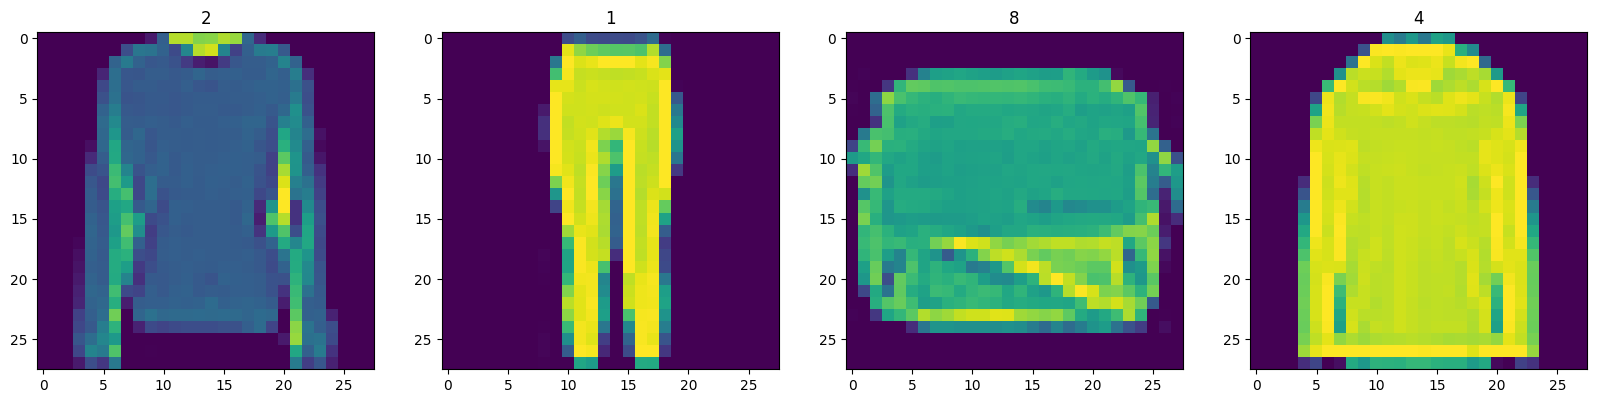

In [35]:
import numpy as np
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [36]:
def scale_image(data):
  img = data['image']
  return img / 255

#### Data pipeline for tensorflow
* map
* cache
* shuffle
* batch
* prefetch

In [37]:
# Reload the dataset
ds = tfds.load('fashion_mnist',split='train')
# Running the dataset throught the scale images preprocessing step
ds = ds.map(scale_image)
# Cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [38]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3 Build a neural network

### 3.1 Import modelling components

In [39]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

### 3.2 Build a generator

In [40]:
# Build a generator
def build_generator():
  model = Sequential()

  # Takes in random values and reshapes it to 7*7*128
  # Beginnings of a generated image
  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv2D block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv2D block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layer to get one channel
  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))

  return model

In [41]:
generator = build_generator()

In [42]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [43]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 90ms/step


(4, 28, 28, 1)

In [44]:
img.shape

(4, 28, 28, 1)

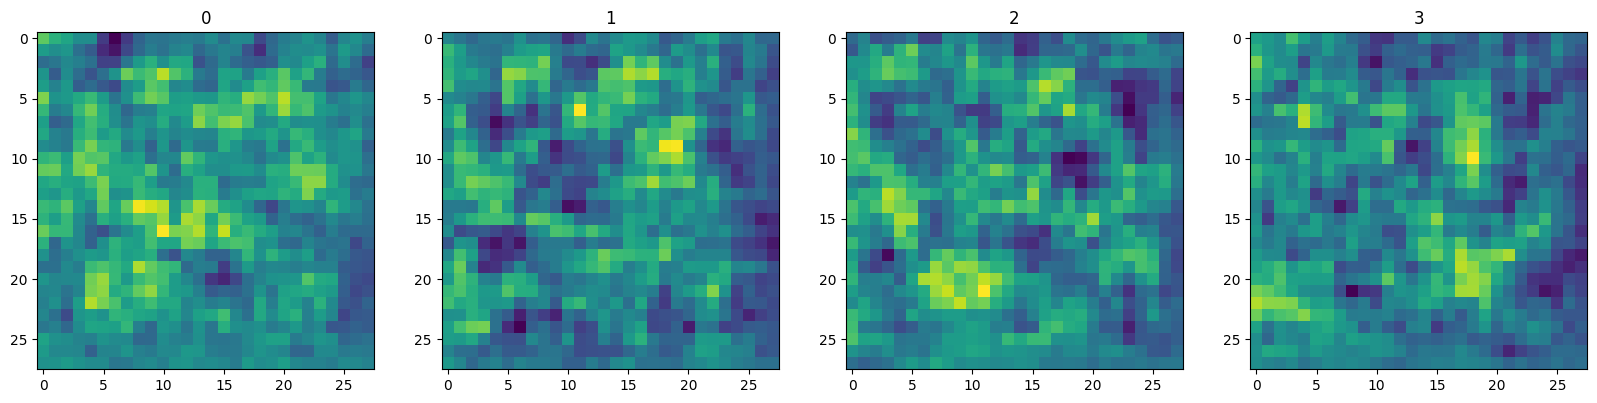

In [45]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

### 3.3 Build a discriminator

In [46]:
from keras.api._v2.keras import activations

def build_discriminator():
  model = Sequential()

  # Conv block 1
  model.add(Conv2D(32,5,input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv block 2
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv block 3
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv block 4
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten and then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  return model

In [47]:
discriminator = build_discriminator()

In [48]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [51]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 1s 945ms/step


array([[0.50168306]], dtype=float32)